<a href="https://colab.research.google.com/github/ricospeloacaso/python_para_investimentos/blob/master/24_BackTesting_de_Carteira_com_Python_(BT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Python para Investimentos - BackTesting de Carteira com Python (BT)

**Canal no Youtube:** https://www.youtube.com/ricospeloacaso?sub_confirmation=1

Link para o Vídeo: https://youtu.be/Ag9-Hn5A0Og

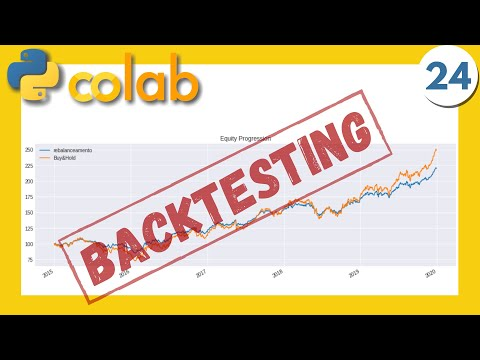

In [1]:
#@title Vídeo
from IPython.display import YouTubeVideo
YouTubeVideo('Ag9-Hn5A0Og', width=854, height=480)

## Biblioteca de Backtesting BT

Documentação: https://pmorissette.github.io/bt/

## Instalação e configurações Iniciais

In [9]:
!pip install bt

   ---------------------------------------- 0.0/217.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/217.0 kB ? eta -:--:--
   ---------------- ----------------------- 92.2/217.0 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 217.0/217.0 kB 1.7 MB/s eta 0:00:00


In [40]:
# Importa as bibliotecas
!pip install python-bcb

In [44]:
# Sistema Gerenciador de Séries Temporais do Banco Central
from bcb import sgs

In [46]:
import bt
import yfinance as yf

import pandas as pd
import matplotlib
matplotlib.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

##Funções

In [49]:
# https://dadosabertos.bcb.gov.br/
# https://pypi.org/project/python-bcb/
def consulta_bc(codigo_bcb):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

In [51]:
#cdi = consulta_bc(12)
# limitado a dez anos
#cdi = sgs.get({'cdi':12}, start = '2016-01-01')

In [55]:
def cdi_acumulado(data_inicio, data_fim):
  #cdi = consulta_bc(12)
  cdi = sgs.get({'cdi':12}, start = '2016-01-01')
  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

##Obtendo e tratando os dados

In [98]:
data_inicio = '2016-01-01'
data_fim    = '2025-05-31'

In [100]:
cdi = cdi_acumulado(data_inicio=data_inicio, data_fim=data_fim)

In [101]:
tickers_carteira = ['BOVA11.SA', 'SMAL11.SA']

In [102]:
carteira = yf.download(tickers_carteira, start=data_inicio, end=data_fim)['Close']

[*********************100%***********************]  2 of 2 completed


In [103]:
carteira['renda_fixa'] = cdi
carteira.dropna(inplace=True)

In [104]:
carteira

Ticker,BOVA11.SA,SMAL11.SA,renda_fixa
Date,,,
2016-01-04,41.099998,39.939999,1.000000
2016-01-05,41.180000,39.610001,1.001050
2016-01-06,40.500000,39.279999,1.001576
2016-01-07,39.470001,38.599998,1.002101
2016-01-08,39.340000,38.759998,1.002628
...,...,...,...
2025-05-22,134.050003,105.050003,2.241048
2025-05-23,134.470001,104.949997,2.242264
2025-05-26,135.009995,105.989998,2.243481


##Backtesting

In [106]:
# estratégia: compra no final do mês, 1/3 para cada ativo (bova11, smal11, cdi)
rebalanceamento = bt.Strategy('rebalanceamento', 
                [bt.algos.RunMonthly(run_on_end_of_period=True),
                 bt.algos.SelectAll(),
                 bt.algos.WeighEqually(),
                 # executa a estratégia
                 bt.algos.Rebalance()])

In [107]:
buy_hold = bt.Strategy('Buy&Hold', 
                   [ bt.algos.RunOnce(),
                     bt.algos.SelectAll(),
                     bt.algos.WeighEqually(),
                     bt.algos.Rebalance()]
                    )

In [108]:
bt1 = bt.Backtest(rebalanceamento, carteira)
# sem renda fixa
bt2 = bt.Backtest(buy_hold, carteira[['BOVA11.SA', 'SMAL11.SA']])

In [109]:
resultados = bt.run(bt1, bt2)

100%|██████████| 2/2 [00:00<00:00,  4.40it/s]


#Resultados

In [111]:
resultados.display()

Stat                 rebalanceamento    Buy&Hold
-------------------  -----------------  ----------
Start                2016-01-03         2016-01-03
End                  2025-05-28         2025-05-28
Risk-free rate       0.00%              0.00%

Total Return         193.17%            201.23%
Daily Sharpe         0.80               0.61
Daily Sortino        1.24               0.93
CAGR                 12.12%             12.45%
Max Drawdown         -33.86%            -49.27%
Calmar Ratio         0.36               0.25

MTD                  3.76%              4.89%
3m                   13.23%             17.83%
6m                   12.31%             14.79%
YTD                  15.66%             20.37%
1Y                   12.10%             11.82%
3Y (ann.)            7.31%              4.09%
5Y (ann.)            8.06%              6.47%
10Y (ann.)           12.12%             12.45%
Since Incep. (ann.)  12.12%             12.45%

Daily Sharpe         0.80               0.61
Daily 

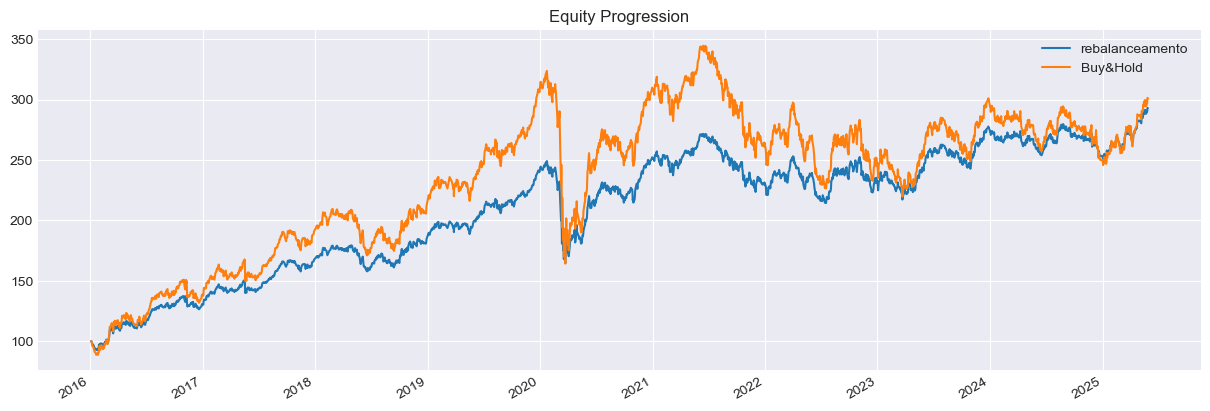

In [112]:
resultados.plot();

###Operações

In [114]:
resultados.get_transactions()

price  quantity
Date       Security                        
2016-01-04 BOVA11.SA    41.099998    8110.0
           SMAL11.SA    39.939999    8345.0
           renda_fixa    1.000000  333333.0
2016-01-29 BOVA11.SA    39.189999     135.0
           SMAL11.SA    37.709999     224.0
...                           ...       ...
2025-03-31 SMAL11.SA    93.419998    -193.0
           renda_fixa    2.199812   14111.0
2025-04-30 BOVA11.SA   131.630005      67.0
           SMAL11.SA   101.500000    -380.0
           renda_fixa    2.223039   13446.0

[338 rows x 2 columns]

###Pesos

In [116]:
resultados.get_security_weights() # pesos ao longo das negociações

,BOVA11.SA,SMAL11.SA,renda_fixa
2016-01-03,0.000000,0.000000,0.000000
2016-01-04,0.333321,0.333299,0.333333
2016-01-05,0.334557,0.331127,0.334270
2016-01-06,0.331722,0.331052,0.337179
2016-01-07,0.327873,0.329937,0.342143
...,...,...,...
2025-05-22,0.332637,0.338058,0.329287
2025-05-23,0.333380,0.337433,0.329170
2025-05-26,0.333099,0.339128,0.327755
2025-05-27,0.333071,0.342492,0.324421


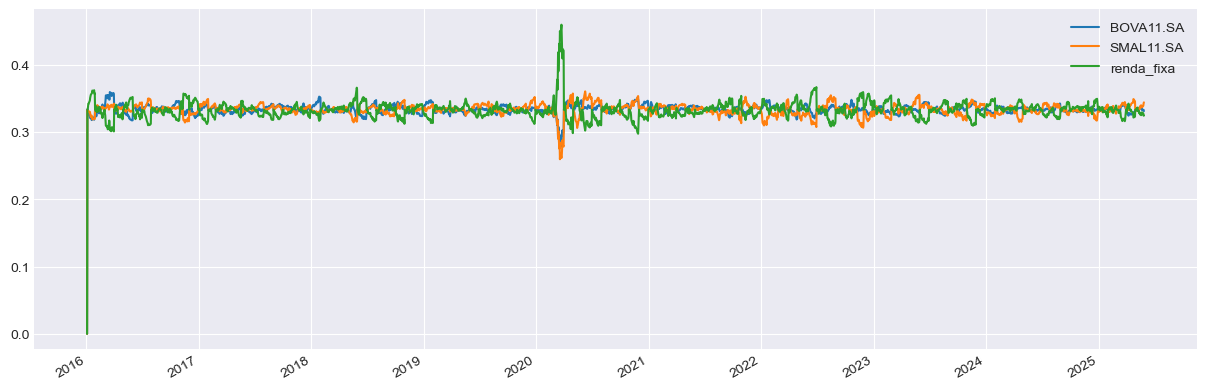

In [117]:
resultados.plot_security_weights() # gráfico dos pesos